## Sensitivity encoded MRI reconstruction

* __Two sets of data were acquired with 4-shot spin-echo EPI at different echo times__
* __The matrix size for each echo image is $128 \times 128 \times 8 $  (xres=128; yres=128; coil_number=8)__

In [13]:
push!(LOAD_PATH,"library");
using PyPlot
using NK_tools

In [14]:
fid = open("data/kdata_4s_seepi");
kdata_4s_seepi = read(fid, Complex128,(128,128,8,2));
close(fid);

In [15]:
kdata_echo1 = kdata_4s_seepi[:,:,:,1];
kdata_echo2 = kdata_4s_seepi[:,:,:,2];

In [16]:
imgdata_echo1 = qft(copy(kdata_echo1));
imgdata_echo2 = qft(copy(kdata_echo2));

11796481179648

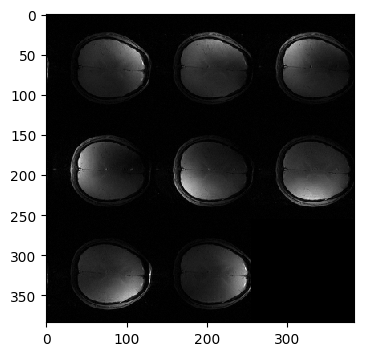

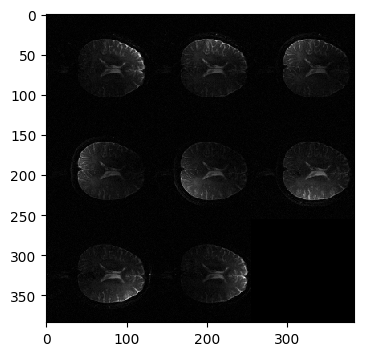

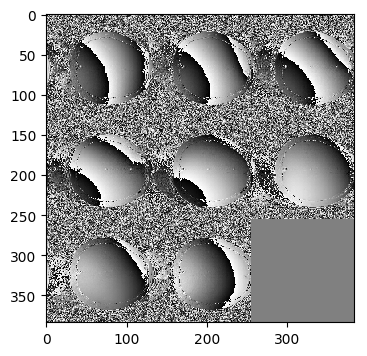

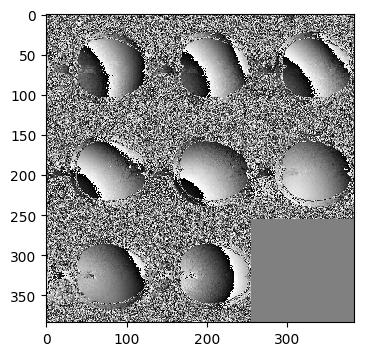

11796481179648

In [17]:
figure(1,figsize=(4,4));imal(abs.(imgdata_echo1),3,3)
figure(2,figsize=(4,4));imal(abs.(imgdata_echo2),3,3)
figure(3,figsize=(4,4));imal(angle.(imgdata_echo1),3,3)
figure(4,figsize=(4,4));imal(angle.(imgdata_echo2),3,3);

* __We could combine the information from 8 RF coil channels with "root-mean-square"__

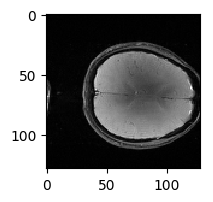

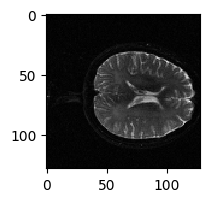

In [6]:
combinedData_echo1 = rmsCombineDataCoils(imgdata_echo1);
combinedData_echo2 = rmsCombineDataCoils(imgdata_echo2);
figure(1,figsize=(2,2));imshow(combinedData_echo1[:,:,1],cmap="gray")
figure(2,figsize=(2,2));imshow(combinedData_echo2[:,:,1],cmap="gray");

* __Calculation of coil sensitivity profiles from the first echo image__

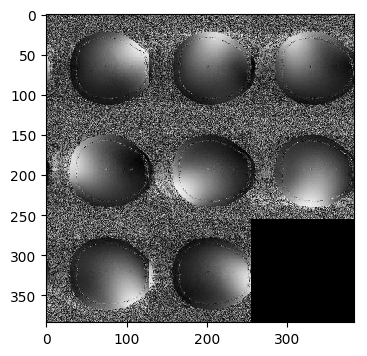

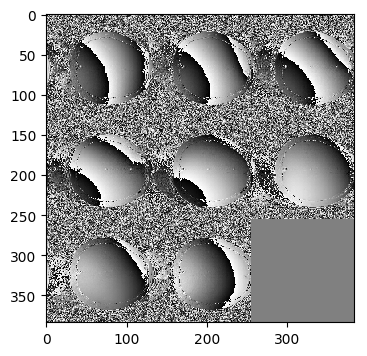

11796481179648

In [7]:
coilSensitivityProfile1 = imgdata_echo1./combinedData_echo1;
figure(1,figsize=(4,4));imal(abs.(coilSensitivityProfile1),3,3)
figure(2,figsize=(4,4));imal(angle.(coilSensitivityProfile1),3,3);

* __Assuming that we have only acquied 50% of the k-space data for echo image 2 (with only odd ky lines acquired), what would the reconstructed images look like?__

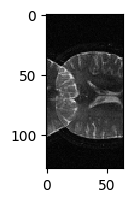

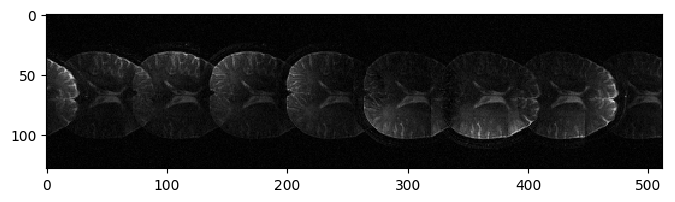

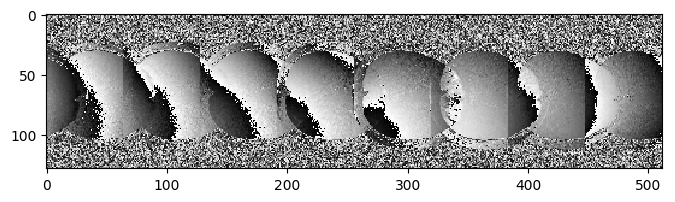

524288524288

In [8]:
kData_acquired = kdata_echo2[:,1:2:end,:];
imgdata_acquired = qft(copy(kData_acquired));
figure(1,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray")
figure(2,figsize=(8,2));imal(abs.(imgdata_acquired),8,1)
figure(3,figsize=(8,2));imal(angle.(imgdata_acquired),8,1);

* __Does zero-filling k-space data change anything?__

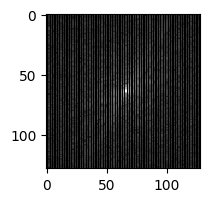

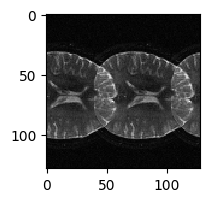

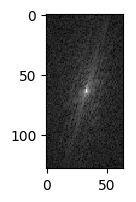

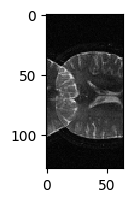

In [9]:
kData_acquired_zeroFilled = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*2,size(kData_acquired)[3]);
kData_acquired_zeroFilled[:,1:2:end,1:4] = kData_acquired;
imgdata_acquired_zeroFilled = qft(copy(kData_acquired_zeroFilled))
figure(1,figsize=(2,2));imshow(abs.(kData_acquired_zeroFilled[:,:,1]).^0.3,cmap="gray");
figure(2,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired_zeroFilled)[:,:,1],cmap="gray");
figure(3,figsize=(2,2));imshow(abs.(kData_acquired[:,:,1]).^0.3,cmap="gray");
figure(4,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray");

* __Recovering FOV and aliasing-free images from under-sampled data using the coil sensitivity profiles__

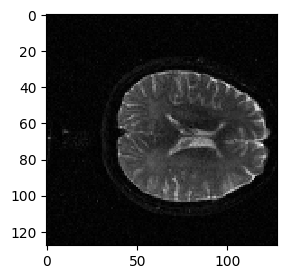

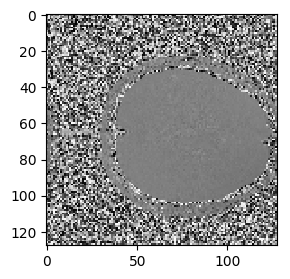

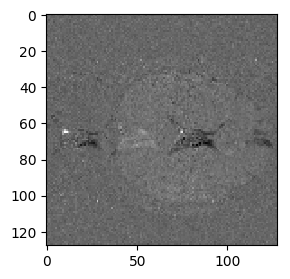

In [10]:
sense_reconstructed_image = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*2);
for cntx = 1:size(kData_acquired)[1]
    for cnty = 1: size(kData_acquired)[2]
        mat1 = imgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+size(kData_acquired)[2],:])
        mat3 = mat2\mat1;
        sense_reconstructed_image[cntx,cnty]=mat3[1];
        sense_reconstructed_image[cntx,cnty+size(kData_acquired)[2]]=mat3[2];
    end
end
figure(1,figsize=(3,3));imshow(abs.(sense_reconstructed_image),cmap="gray")
figure(2,figsize=(3,3));imshow(angle.(sense_reconstructed_image),cmap="gray")
figure(3,figsize=(3,3));imshow(abs.(sense_reconstructed_image)*2-combinedData_echo2[:,:,1],cmap="gray");

### Questions and exercise

* ##### Can we simply average information from 8 RF channels instead using room-mean-square?
    * No because the phase information would be factored into the integrated image. Even though each RF coil (RF channel) are detecting signals from the same slice (thus detecting the same anatomy), Each of the RF coils are set to detect a specific phase shift from the center larmor frequency (and thus a specific spatial region of the anatomy). Therefore, if you average the information from each channel, you will integrate a number of complex value weights over the entire image, hence resulting in an unintelligible image.
* ##### What if we have only 4 RF channels? will the SENSE reconstruction work?
    * Based on executing the code below (code with minor changes to the code above), SENSE reconstruction can still work with 4 RF channels, the quality of the resulting image though depends on the location (or the phase shifts recieved at the specific coil). If the first 4 RF coils are used (coils located right next to eachother or coils recieving Larmor phase shifts that are relatively close to the center Larmor frequency), then the SENSE reconstruction appears to lose information in a specific anatomical region, the region depending on the which coils were used). However, if every other RF coil is used of the 8 (so 4 RF coils still being used but now their positioning relative to eachother is further apart or the induced phase shifts recieved at the 4 RF coils are now more dispersed relative to eachother and from the center Larmor frequency), then the SENSE reconstruction can yield an image with quality comparable to the SENSE reconstruction when all 8 RF coils are being used. 
* ##### What if we have only 2 RF channels? will the SENSE reconstruction work?
    * SENSE reconstruction does not seem to work if only 2 RF coil channels are being used, regardless of the RF coils location. 2 RF coils does not seem to allow for enough k-space data to reconstruct an adequate image, or at least for the FOV of the images used in this notebook.
* ##### Should we smooth coil sensitivity profiles? Will that improve the SNR of SENSE-reconstructed images?
    * If "smoothing" coil sensitivity profiles means to make sensitivity profiles separation more continuous (in smaller increments), then the benefit on SNR when "smoothing" sensitivity profiles depends on the FOV of the anatomy and the resolution that is wanted. Based on FOV and needed resolution, the sensitivity profiles have to be optimized to maximize image quality.
* ##### How can we use regularization to reduce noise amplification?
    * The shorter scan time (which can be decreased with increasing number k-space lines and number of RF coils used), the more the SNR is decreased (the noise is amplified). Maybe we can introduce a correction factor that reduces the impact of shorter scan time on noise amplificaition, since shorter scan times is often desired. This seems to be the purpose of the g-factor (geometery factor). If the g-factor is increased as scan time is decreased, then no noise amplification would occur.  
* #### Can we reconstruct full FOV images from only 25% of the k-space data (e.g., $k_y$ line # 1, 5, 9 ...)?
    * Based on the overlapping aliasing, it appears that 25% of the k-space data is not suffcient to generate a SENSE image. Reducing the k-space data to 25% apparently reduced the FOV of the image such that the actual object extended beyond the FOV.

#### Practice Test Code (copied from above but with minor changes)

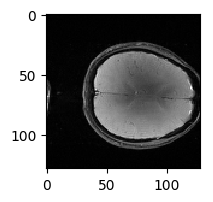

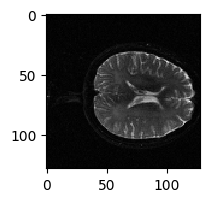

In [97]:
# We could combine the information from range "x" of RF coil channels at locations "p" with "root-mean-square"
numRFcoil = 8; # total number of ordered RF coils want to consider. If "8" then considering all coils. If "4" then consdiering the first 4 RF coils.

rfCoilSkipPos = 1; #number of rf coils skip from first. If "1" then no skiping, if "2" then taking every other RF coil

combinedData_echo1 = rmsCombineDataCoils(imgdata_echo1[:,:,1:rfCoilSkipPos:numRFcoil]);
combinedData_echo2 = rmsCombineDataCoils(imgdata_echo2[:,:,1:rfCoilSkipPos:numRFcoil]);
figure(1,figsize=(2,2));imshow(combinedData_echo1[:,:,1],cmap="gray")
figure(2,figsize=(2,2));imshow(combinedData_echo2[:,:,1],cmap="gray");

11796481179648

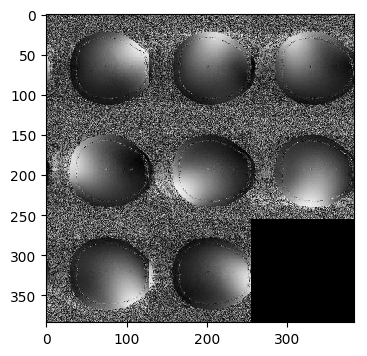

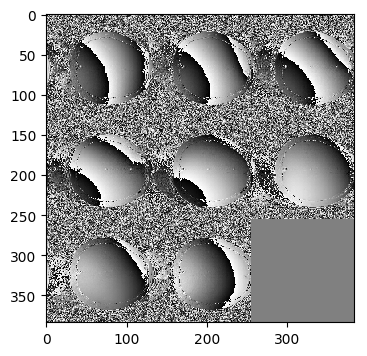

In [98]:
# Calculation of coil sensitivity profiles from the first echo image

coilSensitivityProfile1 = imgdata_echo1[:,:,1:rfCoilSkipPos:numRFcoil]./combinedData_echo1
figure(1,figsize=(4,4));imal(abs.(coilSensitivityProfile1),3,3);
figure(2,figsize=(4,4));imal(angle.(coilSensitivityProfile1),3,3);

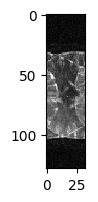

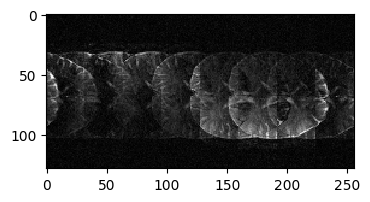

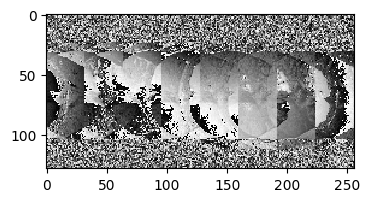

262144262144

In [99]:
#Assuming that we have only acquried some percentage of the k-space data for echo image 2 (with only odd ky lines acquired), what #would the reconstructed images look like?

kSpacePercentage = 4 # "4" is 25%, "2" is 50% of k-space data

kData_acquired = kdata_echo2[:,1:kSpacePercentage:end,1:rfCoilSkipPos:numRFcoil];
imgdata_acquired = qft(copy(kData_acquired));
figure(1,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray")
figure(2,figsize=(8,2));imal(abs.(imgdata_acquired),8,1)
figure(3,figsize=(8,2));imal(angle.(imgdata_acquired),8,1);

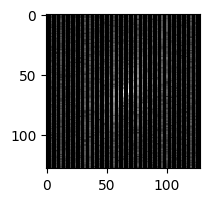

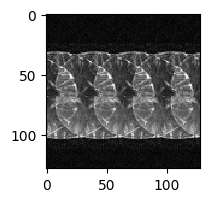

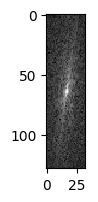

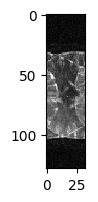

In [100]:
#Does zero-filling k-space data change anything?

kData_acquired_zeroFilled = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*kSpacePercentage,size(kData_acquired)[3]);
kData_acquired_zeroFilled[:,1:kSpacePercentage:end,:] = kData_acquired;
imgdata_acquired_zeroFilled = qft(copy(kData_acquired_zeroFilled))
figure(1,figsize=(2,2));imshow(abs.(kData_acquired_zeroFilled[:,:,1]).^0.3,cmap="gray");
figure(2,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired_zeroFilled)[:,:,1],cmap="gray");
figure(3,figsize=(2,2));imshow(abs.(kData_acquired[:,:,1]).^0.3,cmap="gray");
figure(4,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray");

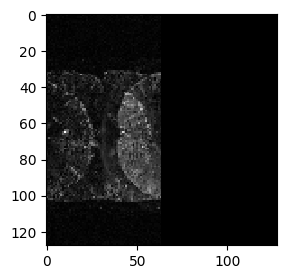

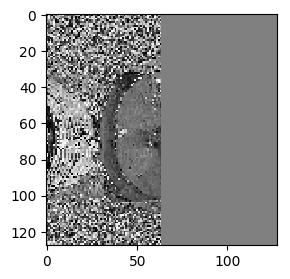

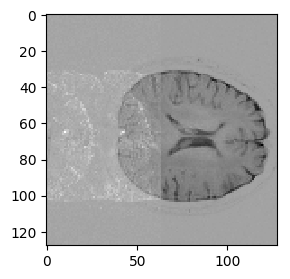

In [101]:
#Recovering FOV and aliasing-free images from under-sampled data using the coil sensitivity profiles

sense_reconstructed_image = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*kSpacePercentage);
for cntx = 1:size(kData_acquired)[1]
    for cnty = 1: size(kData_acquired)[2]
        mat1 = imgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+size(kData_acquired)[2],:])
        mat3 = mat2\mat1;
        sense_reconstructed_image[cntx,cnty]=mat3[1];
        sense_reconstructed_image[cntx,cnty+size(kData_acquired)[2]]=mat3[2];
    end
end
figure(1,figsize=(3,3));imshow(abs.(sense_reconstructed_image),cmap="gray")
figure(2,figsize=(3,3));imshow(angle.(sense_reconstructed_image),cmap="gray")
figure(3,figsize=(3,3));imshow(abs.(sense_reconstructed_image)*2-combinedData_echo2[:,:,1],cmap="gray");